In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import ktplotspy as kpy
import scipy.sparse as sparse

In [2]:
adata = sc.read_h5ad("/data/yypdata/NMF/Benchmark/cellphoneDB/Single_cell_atlas_COVID_sparse.h5ad")

In [3]:
from tqdm import tqdm

cell_types = adata[adata.obs['Status'] == 'COVID'].obs['cell_type_coarse'].unique().tolist()
deg_dict = {}

for ct in tqdm(cell_types):
    adata_sub = adata[adata.obs['cell_type_coarse'] == ct].copy()
        sc.tl.rank_genes_groups(
        adata_sub, 
        groupby='Status', 
        groups=['COVID'], 
        reference='Healthy',
        method='wilcoxon',
        pts=True
    )
    
    deg_df = sc.get.rank_genes_groups_df(adata_sub, group='COVID')
    deg_df['cell_type'] = ct
    up_genes = deg_df[(deg_df['logfoldchanges'] > 0.5) & (deg_df['pvals_adj'] < 0.05)]
    
    deg_dict[ct] = up_genes[['cell_type','names', 'logfoldchanges', 'pvals_adj']]

deg = pd.concat(deg_dict.values()).reset_index(drop=True)[['cell_type','names']]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:48<00:00,  3.71s/it]


In [10]:
deg = pd.read_csv('/data/yypdata/NMF/Benchmark/cellphoneDB/deg.tsv',sep='\t')
#deg.to_csv('/data/yypdata/NMF/Benchmark/cellphoneDB/deg.tsv', sep = '\t',index=None)

In [3]:
adata = adata[adata.obs['Status'] == 'COVID', :].copy()
#adata.write('/data/yypdata/NMF/Benchmark/cellphoneDB/COVID.h5ad')

In [71]:
df_meta = pd.DataFrame(data={'Cell':list(adata.obs.index),
                             'cell_type':[ i for i in adata.obs['cell_type_coarse']]
                            })
df_meta.set_index('Cell', inplace=True)
df_meta.to_csv('/data/yypdata/NMF/Benchmark/cellphoneDB/meta.tsv', sep = '\t')

In [72]:
df_meta

,cell_type
Cell,
covid_555_1.1,RBC
covid_555_1.2,B
covid_555_1.3,PB
covid_555_1.7,B
covid_555_1.8,PB
...,...
covid_561.3750,CD14 Monocyte
covid_561.3751,CD14 Monocyte
covid_561.3752,CD14 Monocyte


In [4]:
cpdb_file_path = '/data/yypdata/NMF/Benchmark/cellphoneDB/cellphonedb.zip'
meta_file_path = '/data/yypdata/NMF/Benchmark/cellphoneDB/meta.tsv'
counts_file_path = '/data/yypdata/NMF/Benchmark/cellphoneDB/COVID.h5ad'
degs_file_path = '/data/yypdata/NMF/Benchmark/cellphoneDB/deg.tsv'
microenvs_file_path = None
active_tf_path = None
out_path ='/data/yypdata/NMF/Benchmark/cellphoneDB/cellphone'

In [5]:
from cellphonedb.src.core.methods import cpdb_degs_analysis_method

cpdb_results = cpdb_degs_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                            # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                            # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,                        # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    degs_file_path = degs_file_path,                            # mandatory: tsv file with DEG to account.
    counts_data = 'hgnc_symbol',                                # defines the gene annotation in counts matrix.
    active_tfs_file_path = active_tf_path,                      # optional: defines cell types and their active TFs.
    microenvs_file_path = microenvs_file_path,                  # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                                  # optional: whether to score interactions or not. 
    threshold = 0.1,                                            # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                                       # Sets the rounding for the mean values in significan_means.
    separator = '|',                                            # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                              # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_path = out_path,                                     # Path to save results
    output_suffix = None,                                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
    threads = 25
    )

[ ][CORE][14/04/25-16:57:03][INFO] [Cluster DEGs Analysis] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
/data/yypdata/NMF/Benchmark/cellphoneDB/COVID.h5ad
/data/yypdata/NMF/Benchmark/cellphoneDB/meta.tsv
/data/yypdata/NMF/Benchmark/cellphoneDB/deg.tsv
[ ][CORE][14/04/25-16:57:09][INFO] Running Real Analysis
[ ][CORE][14/04/25-16:57:09][INFO] Running DEGs-based Analysis
[ ][CORE][14/04/25-16:57:09][INFO] Building results
[ ][CORE][14/04/25-16:57:10][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 36.66it/s]

[ ][CORE][14/04/25-16:57:10][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 130.17it/s]
/home/yangyoupeng/anaconda3/envs/torch/lib/python3.10/site-packages/cellphonedb/utils/scoring_utils.py:138: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




[ ][CORE][14/04/25-16:57:11][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:11<00:00, 14.99it/s]


Saved deconvoluted to /data/yypdata/NMF/Benchmark/cellphoneDB/cellphone/degs_analysis_deconvoluted_04_14_2025_165723.txt
Saved deconvoluted_percents to /data/yypdata/NMF/Benchmark/cellphoneDB/cellphone/degs_analysis_deconvoluted_percents_04_14_2025_165723.txt
Saved means to /data/yypdata/NMF/Benchmark/cellphoneDB/cellphone/degs_analysis_means_04_14_2025_165723.txt
Saved relevant_interactions to /data/yypdata/NMF/Benchmark/cellphoneDB/cellphone/degs_analysis_relevant_interactions_04_14_2025_165723.txt
Saved significant_means to /data/yypdata/NMF/Benchmark/cellphoneDB/cellphone/degs_analysis_significant_means_04_14_2025_165723.txt
Saved interaction_scores to /data/yypdata/NMF/Benchmark/cellphoneDB/cellphone/degs_analysis_interaction_scores_04_14_2025_165723.txt


In [4]:
cpdb_results={}
cpdb_results['relevant_interactions'] = pd.read_csv("/data/yypdata/NMF/Benchmark/cellphoneDB/cellphone/degs_analysis_relevant_interactions_04_14_2025_165723.txt",sep='\t')
cpdb_results['means'] = pd.read_csv("/data/yypdata/NMF/Benchmark/cellphoneDB/cellphone/degs_analysis_means_04_14_2025_165723.txt",sep='\t')
cpdb_results['interaction_scores'] = pd.read_csv("/data/yypdata/NMF/Benchmark/cellphoneDB/cellphone/degs_analysis_interaction_scores_04_14_2025_165723.txt",sep='\t')

In [5]:
cpdb_results.keys()

dict_keys(['relevant_interactions', 'means', 'interaction_scores'])

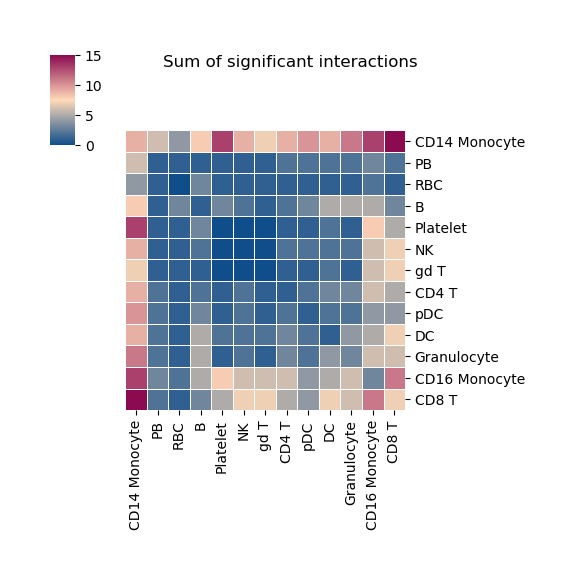

In [6]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['relevant_interactions'],
                      degs_analysis=True,
                      figsize=(5, 5),
                      title="Sum of significant interactions")

In [13]:
deg['cell_type'].unique().tolist()
"CD14 Monocyte|B|PB|CD14 Monocyte|CD8 T|CD4 T|NK|Granulocyte|CD16 Monocyte|pDC|DC"

['RBC',
 'B',
 'PB',
 'CD14 Monocyte',
 'CD8 T',
 'CD4 T',
 'Platelet',
 'NK',
 'Granulocyte',
 'CD16 Monocyte',
 'pDC',
 'DC']

In [17]:
p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "CD14 Monocyte|B|PB|CD14 Monocyte|CD8 T|CD4 T|NK|Granulocyte|CD16 Monocyte|pDC|DC",
    cell_type2 = "CD14 Monocyte|B|PB|CD14 Monocyte|CD8 T|CD4 T|NK|Granulocyte|CD16 Monocyte|pDC|DC", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "cell_type_coarse",
    genes = deg['names'].tolist(),
    figsize = (25,8),
    title = "Interactions between PV and trophoblast ",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True,
    interaction_scores = cpdb_results['interaction_scores'],
    scale_alpha_by_interaction_scores=True,
)
p.save(filename="cellphonedb_res.png", path="/data/yypdata/NMF/Benchmark/cellphoneDB/", dpi=300)
#plt.savefig('/data/yypdata/NMF/Benchmark/cellphoneDB/cellphonedb_res.png',bbox_inches='tight')

/home/yangyoupeng/anaconda3/envs/torch/lib/python3.10/site-packages/ktplotspy/plot/plot_cpdb.py:195: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/home/yangyoupeng/anaconda3/envs/torch/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 25 x 8 in image.
/home/yangyoupeng/anaconda3/envs/torch/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /data/yypdata/NMF/Benchmark/cellphoneDB/cellphonedb_res.png


/home/yangyoupeng/anaconda3/envs/torch/lib/python3.10/site-packages/ktplotspy/plot/plot_cpdb.py:195: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


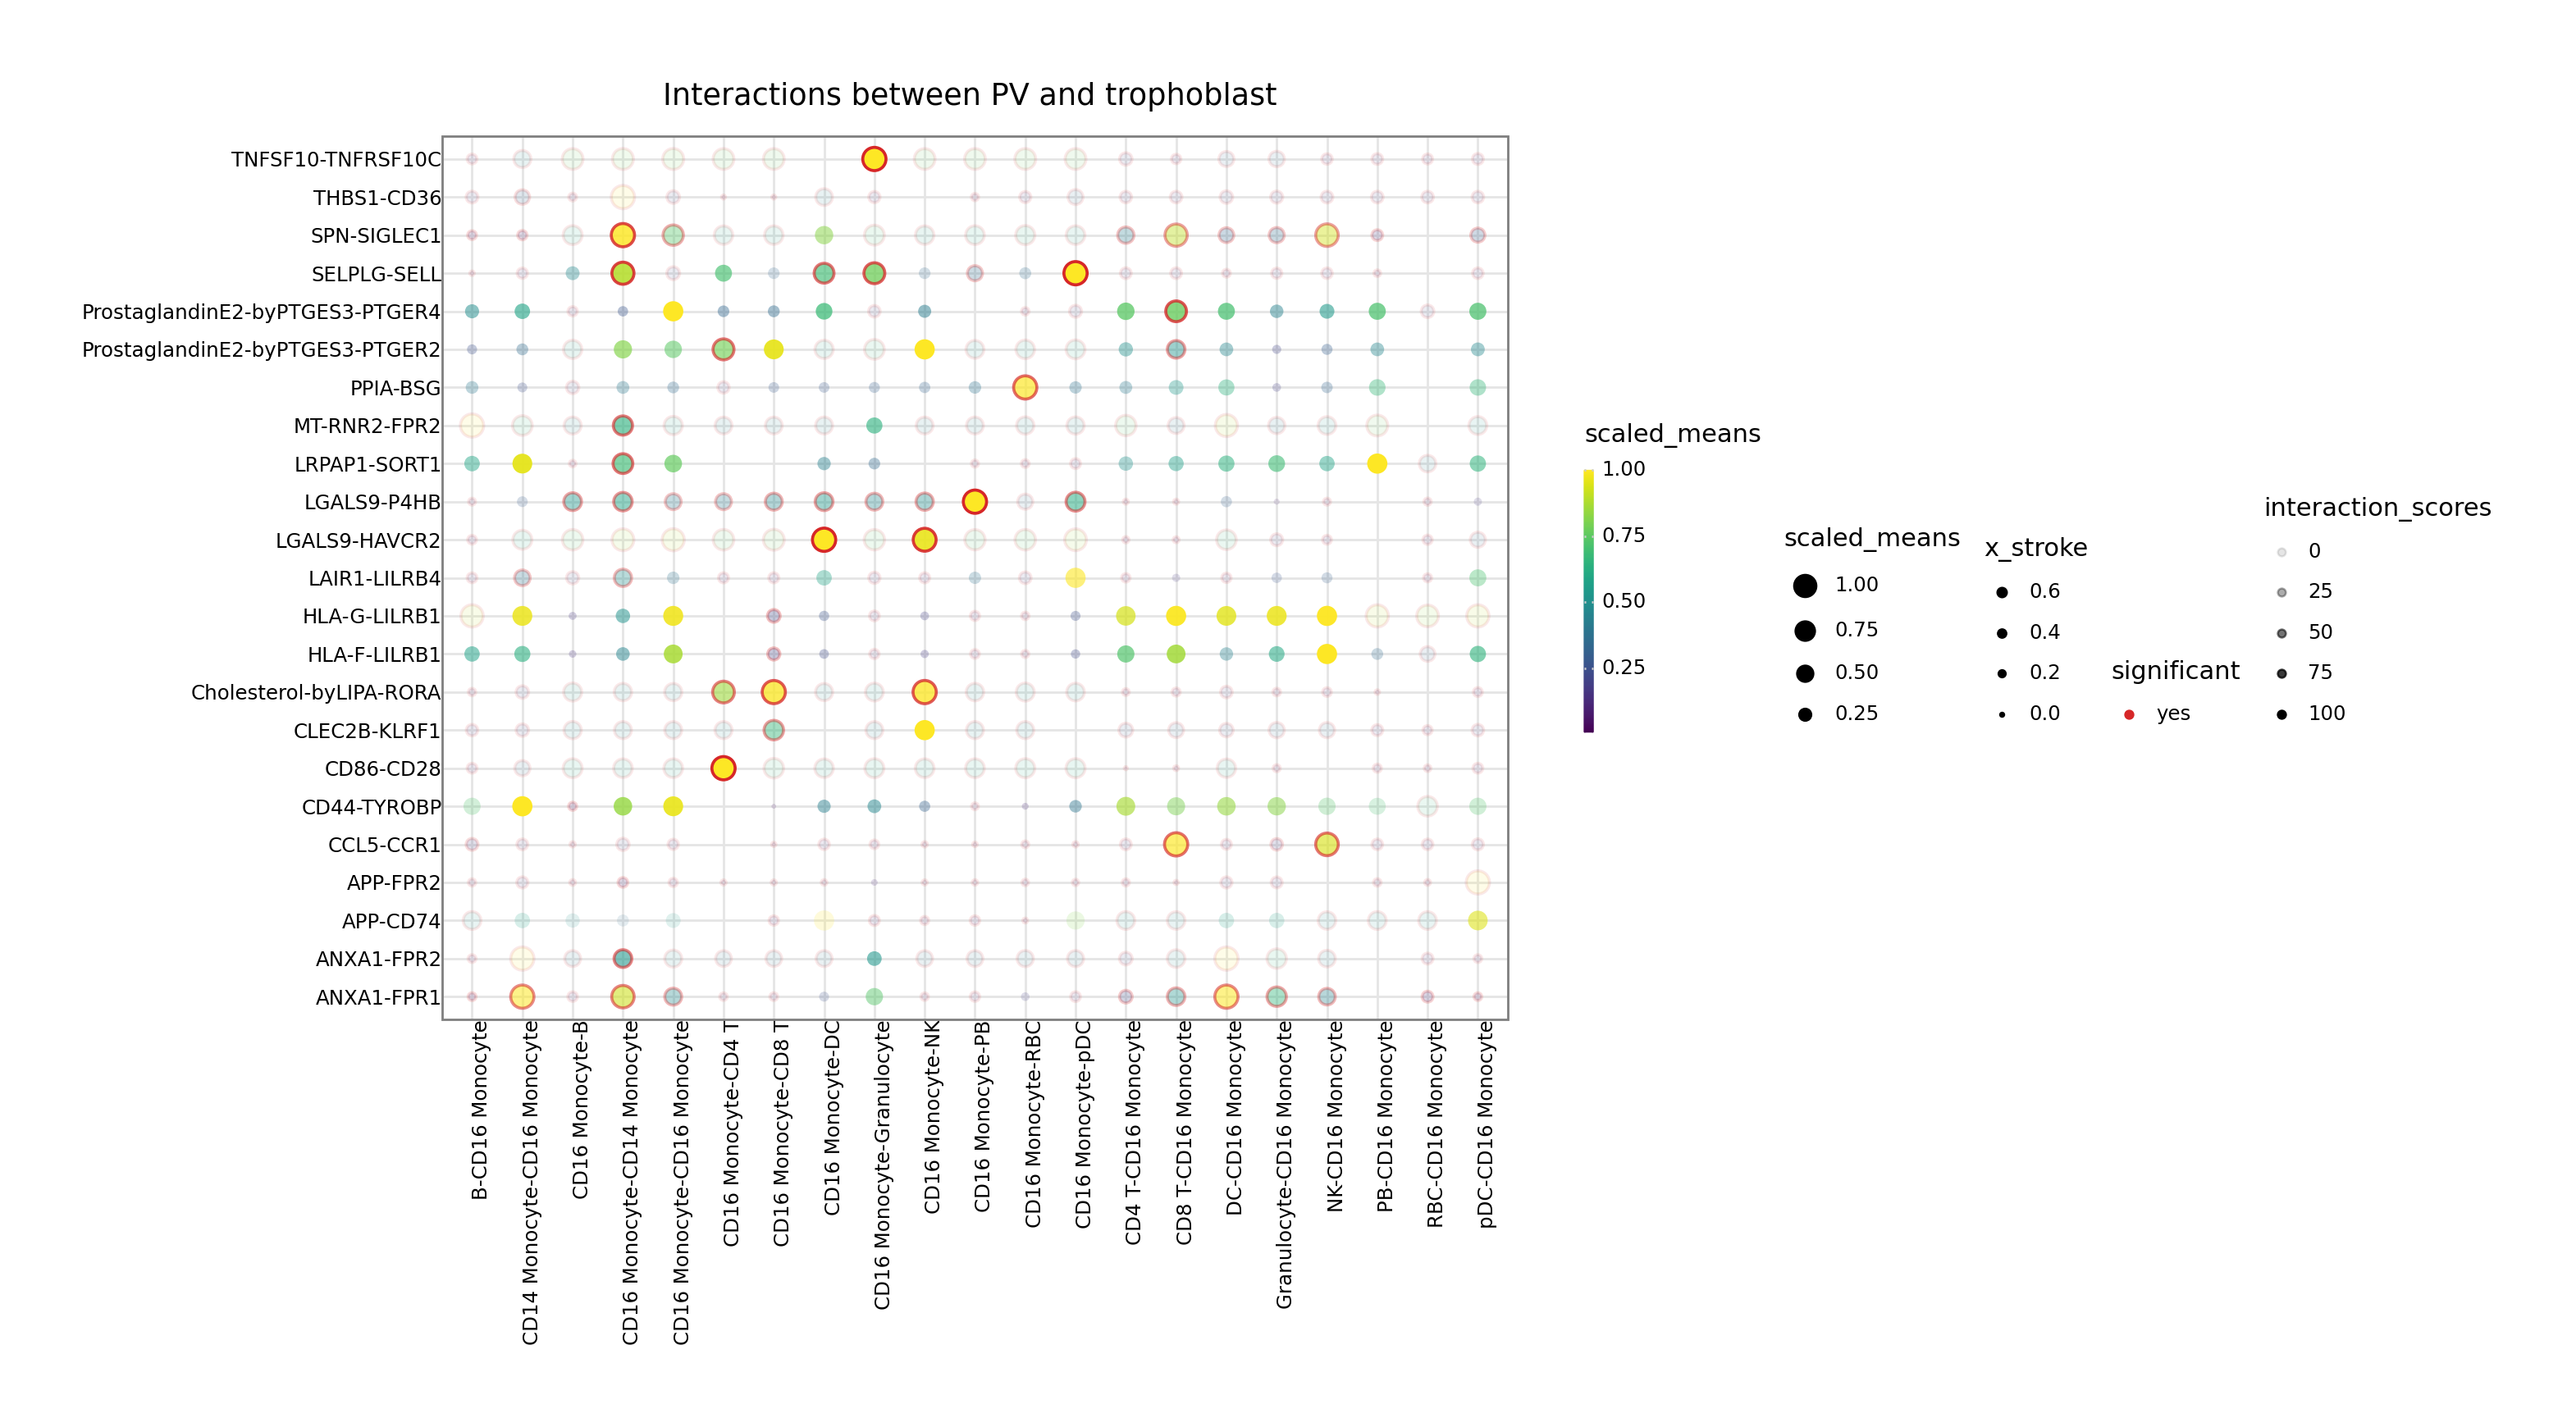

In [77]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "CD14 Monocyte|B|PB|CD14 Monocyte|CD8 T|CD4 T|NK|Granulocyte|CD16 Monocyte|pDC|DC",
    cell_type2 = "CD16 Monocyte", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "cell_type_coarse",
    genes = deg['names'].tolist(),
    figsize = (15,8),
    title = "Interactions between PV and trophoblast ",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True,
    interaction_scores = cpdb_results['interaction_scores'],
    scale_alpha_by_interaction_scores=True,
)

/home/yangyoupeng/anaconda3/envs/torch/lib/python3.10/site-packages/ktplotspy/plot/plot_cpdb.py:195: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


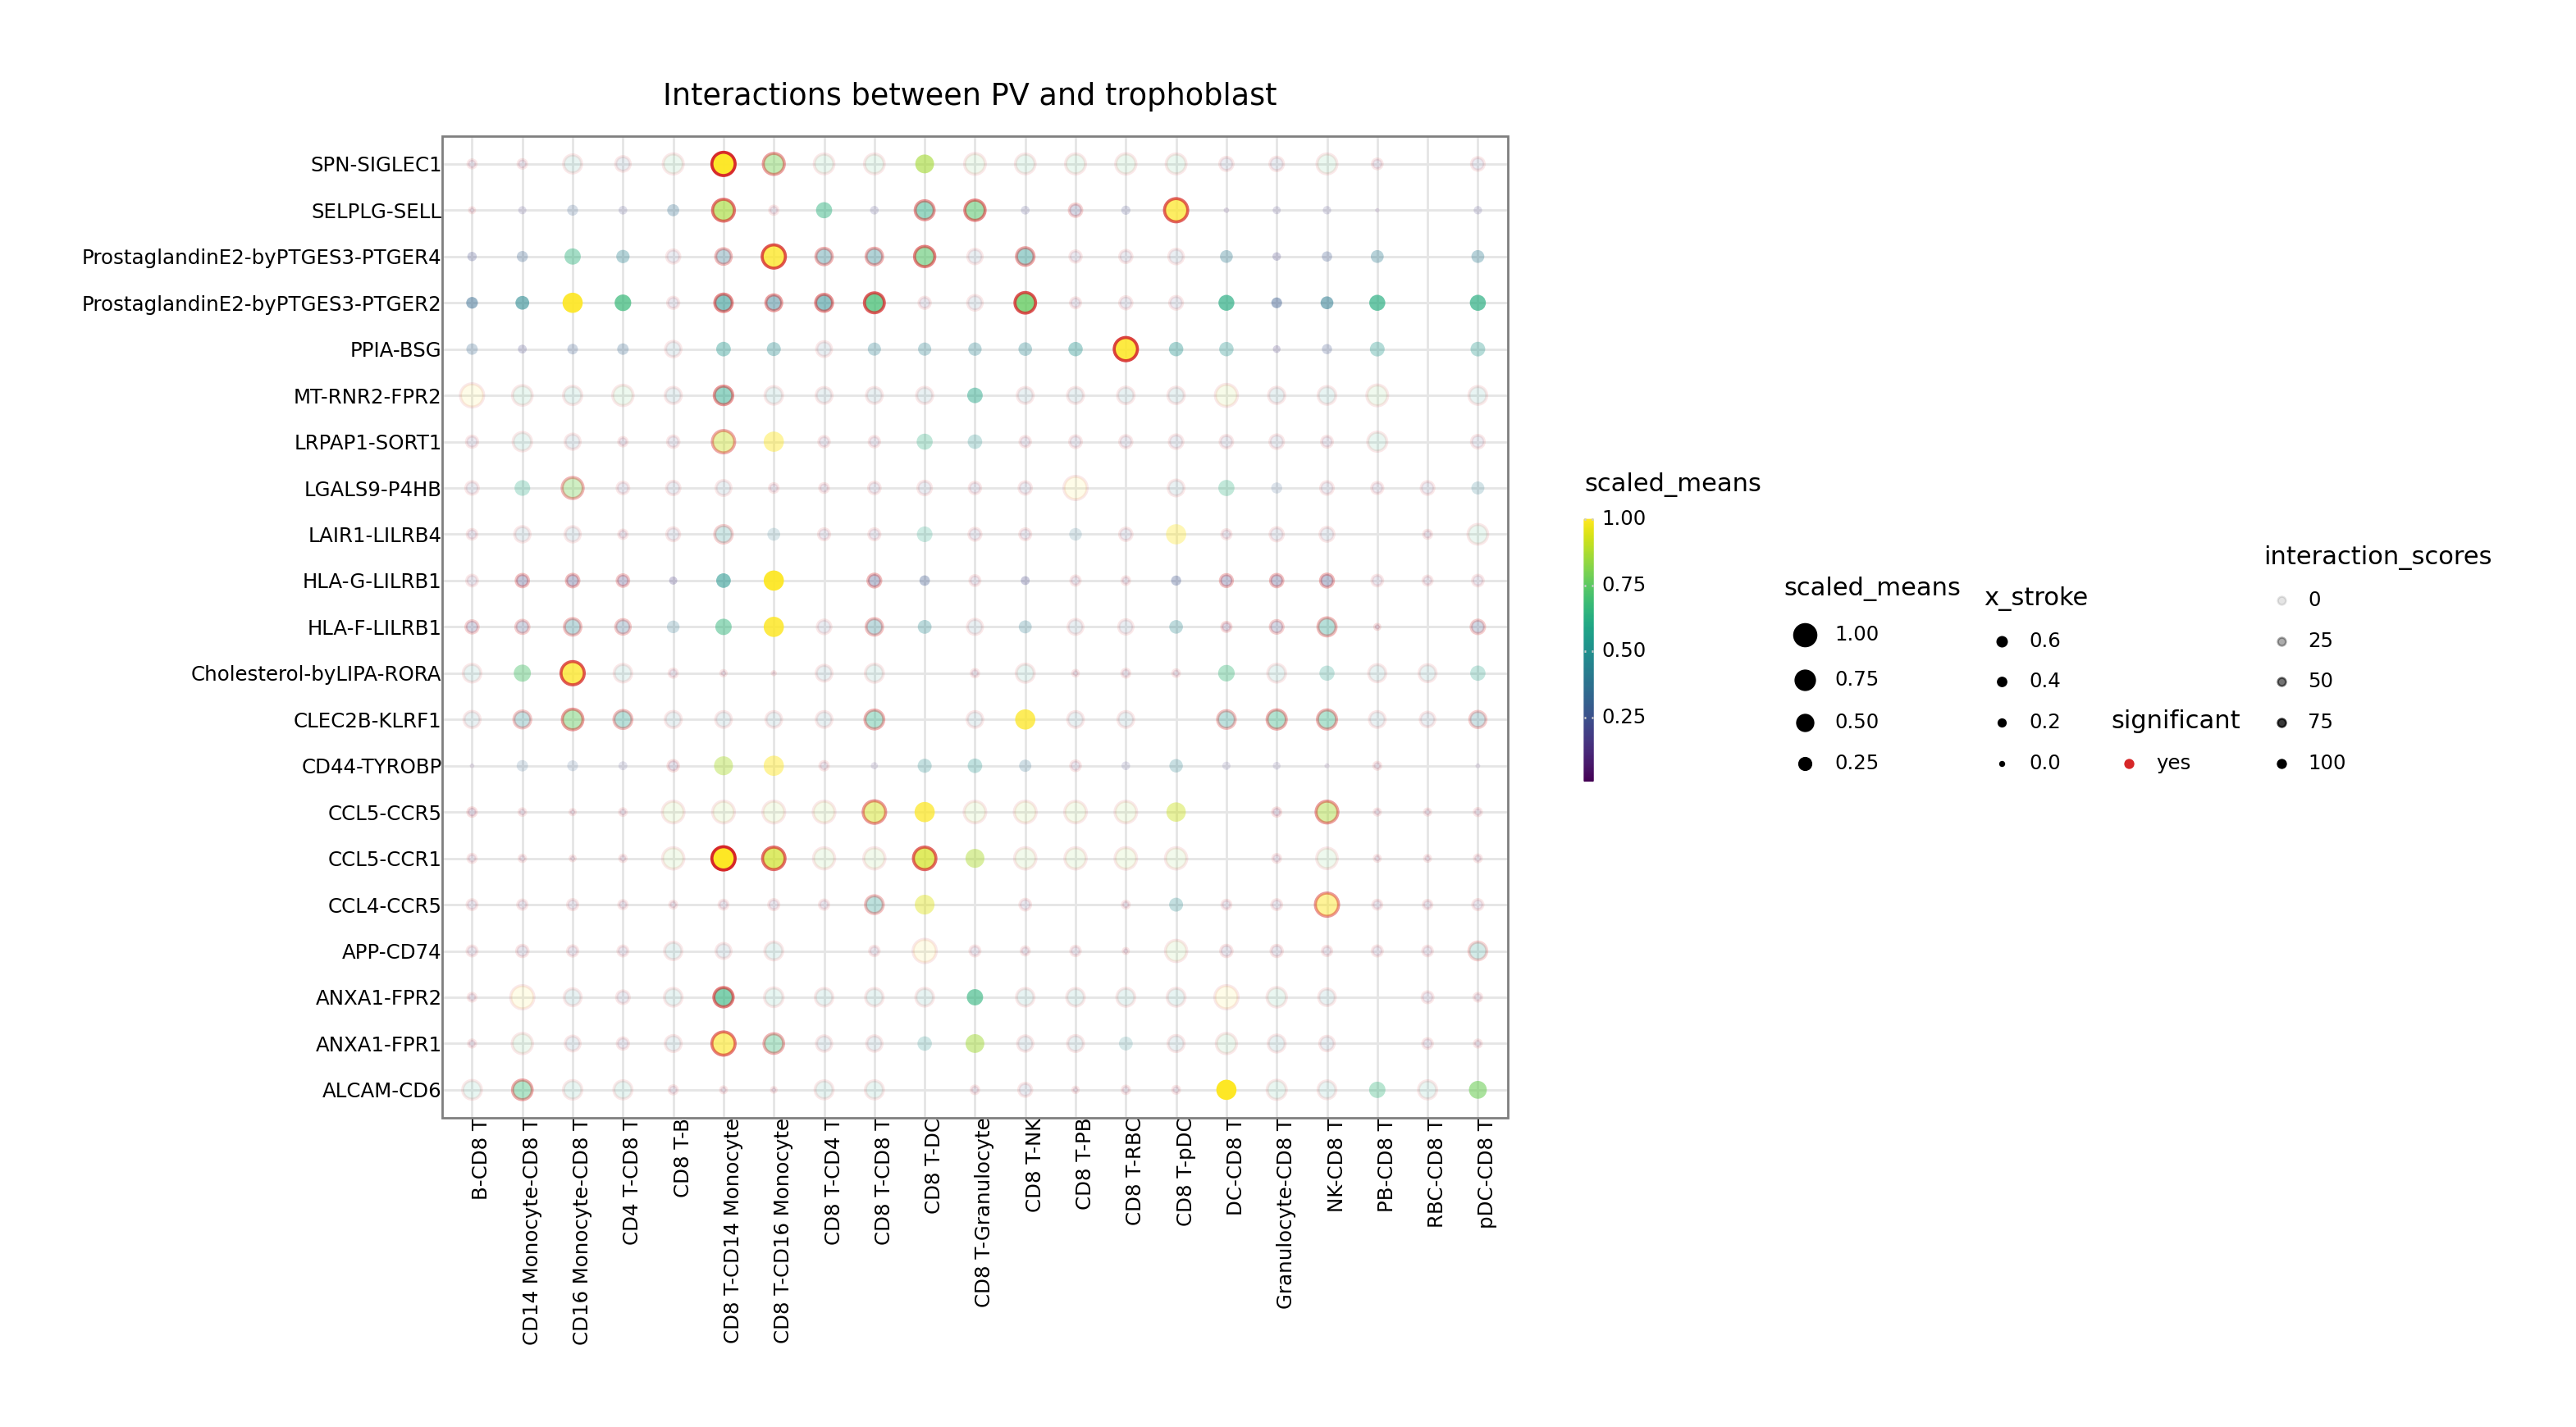

In [78]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "CD8 T",
    cell_type2 = "CD14 Monocyte|B|PB|CD14 Monocyte|CD8 T|CD4 T|NK|Granulocyte|CD16 Monocyte|pDC|DC", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "cell_type_coarse",
    genes = deg['names'].tolist(),
    figsize = (15,8),
    title = "Interactions between PV and trophoblast ",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True,
    interaction_scores = cpdb_results['interaction_scores'],
    scale_alpha_by_interaction_scores=True,
)

In [8]:
cpdb_results.keys()

dict_keys(['deconvoluted', 'deconvoluted_percents', 'means', 'relevant_interactions', 'significant_means', 'CellSign_active_interactions', 'CellSign_active_interactions_deconvoluted', 'interaction_scores'])

In [18]:
cpdb_results['relevant_interactions']#.iloc[:, 13:]

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,pDC|B,pDC|CD14 Monocyte,pDC|CD16 Monocyte,pDC|CD4 T,pDC|CD8 T,pDC|DC,pDC|Granulocyte,pDC|PB,pDC|RBC,pDC|pDC
68,CPI-SS08C411721,CEACAM8_CEACAM6,simple:P31997,simple:P40199,CEACAM8,CEACAM6,False,False,False,curated,...,0,0,0,0,0,0,0,0,0,0
69,CPI-SS0CCDBBBC0,CEACAM1_CEACAM8,simple:P13688,simple:P31997,CEACAM1,CEACAM8,True,False,False,curated,...,0,0,0,0,0,0,0,0,0,0
247,CPI-SC071B77A18,JAM3_integrin_aMb2_complex,simple:Q9BX67,complex:integrin_aMb2_complex,JAM3,NaN,True,False,False,curated,...,0,0,0,0,0,0,0,0,0,0
252,CPI-SC0329DFA42,GP1BA_integrin_aMb2_complex,simple:P07359,complex:integrin_aMb2_complex,GP1BA,NaN,False,False,False,curated,...,0,0,0,0,0,0,0,0,0,0
345,CPI-SS0C93E48D7,THBS1_CD36,simple:P07996,simple:P16671,THBS1,CD36,False,False,True,curated,...,0,0,0,0,0,0,0,0,0,0
483,CPI-SS080C81D37,APP_CD74,simple:P05067,simple:P04233,APP,CD74,False,False,True,curated,...,0,0,0,0,1,0,0,0,0,0
484,CPI-SS0F66EA6BE,APP_FPR2,simple:P05067,simple:P25090,APP,FPR2,False,False,True,curated,...,0,1,0,0,0,0,0,0,0,0
485,CPI-SS030BB46BB,ANXA1_FPR2,simple:P04083,simple:P25090,ANXA1,FPR2,True,False,True,curated,...,0,1,0,0,0,0,0,0,0,0
487,CPI-SS057DF25C1,MT-RNR2_FPR2,simple:Q8IVG9,simple:P25090,MT-RNR2,FPR2,True,False,True,curated,...,0,1,0,0,0,0,0,0,0,0
488,CPI-CS0C94B5884,LipoxinA4_byALOX12_FPR2,complex:LipoxinA4_byALOX12,simple:P25090,NaN,FPR2,True,False,True,curated,...,0,0,0,0,0,0,0,0,0,0


In [8]:
import pandas as pd

relevant_df = cpdb_results['relevant_interactions']
cell_pair_cols = [col for col in relevant_df.columns if '|' in col]

diff_lri_pairs = []
for idx, row in relevant_df.iterrows():
    for col in cell_pair_cols:
        if row[col] == 1: 
            diff_lri_pairs.append({
                'interaction_id': row['id_cp_interaction'],
                'interaction_name': row['interacting_pair'],
                'cell_pair': col,
                'partner_a': row['partner_a'],
                'partner_b': row['partner_b']
            })

diff_lri_df = pd.DataFrame(diff_lri_pairs)
if 'means' in cpdb_results and 'interaction_scores' in cpdb_results:
    means_df = cpdb_results['means']
    scores_df = cpdb_results['interaction_scores']
    diff_lri_df['mean'] = diff_lri_df.apply(
        lambda x: means_df.loc[means_df['id_cp_interaction'] == x['interaction_id'], x['cell_pair']].iloc[0]
        if x['interaction_id'] in means_df['id_cp_interaction'].values else 0, axis=1)

    diff_lri_df['score'] = diff_lri_df.apply(
        lambda x: scores_df.loc[scores_df['id_cp_interaction'] == x['interaction_id'], x['cell_pair']].iloc[0]
        if x['interaction_id'] in scores_df['id_cp_interaction'].values else 0, axis=1)

diff_lri_df = diff_lri_df.sort_values('score', ascending=False) if 'score' in diff_lri_df.columns else diff_lri_df

print("All Differential LRIs (based on relevant_interactions where value = 1):")
print(diff_lri_df[['interaction_name', 'cell_pair', 'mean', 'score', 'partner_a', 'partner_b']])

All Differential LRIs (based on relevant_interactions where value = 1):
                interaction_name                cell_pair   mean    score  \
0                CEACAM8_CEACAM6  Granulocyte|Granulocyte  0.236  100.000   
1                CEACAM1_CEACAM8  Granulocyte|Granulocyte  0.224  100.000   
48       LipoxinA4_byALOX12_FPR2   Platelet|CD14 Monocyte  0.135  100.000   
2     JAM3_integrin_aMb2_complex   Platelet|CD14 Monocyte  0.333  100.000   
4    GP1BA_integrin_aMb2_complex   Platelet|CD14 Monocyte  0.371  100.000   
..                           ...                      ...    ...      ...   
265                  CD44_TYROBP                      B|B  0.179    1.487   
273                  CD44_TYROBP                     PB|B  0.168    1.083   
11                      APP_CD74      CD16 Monocyte|CD8 T  0.261    0.784   
45                  MT-RNR2_FPR2        RBC|CD14 Monocyte  1.920    0.000   
275                  CD44_TYROBP                    RBC|B  0.139    0.000   

   

In [31]:
diff_lri_df['interaction_name'].unique()

array(['CEACAM8_CEACAM6', 'CEACAM1_CEACAM8', 'LipoxinA4_byALOX12_FPR2',
       'JAM3_integrin_aMb2_complex', 'GP1BA_integrin_aMb2_complex',
       'CD86_CD28', 'ANXA1_FPR1', 'SPN_SIGLEC1', 'PPIA_BSG', 'ANXA1_FPR2',
       'SELPLG_SELL', 'NCAM1_FGFR1', 'Cholesterol_byLIPA_RORA',
       'LGALS9_HAVCR2', 'LGALS9_P4HB', 'Cholesterol_byLIPA_RORC',
       'CCL5_CCR1', 'TNFSF10_TNFRSF10C', 'MT-RNR2_FPR2', 'APP_FPR2',
       'THBS1_CD36', 'LRPAP1_SORT1', 'ProstaglandinE2_byPTGES3_PTGER4',
       'ProstaglandinE2_byPTGES3_PTGER2', 'BST2_LILRA4', 'CLEC2B_KLRF1',
       'LAIR1_LILRB4', 'CCL5_CCR5', 'CCL4_CCR5', 'ALCAM_CD6',
       'HLA-G_LILRB1', 'HLA-F_LILRB1', 'APLP2_PLXNA4', 'APP_CD74',
       'CD44_TYROBP'], dtype=object)

In [28]:
relevant_df = cpdb_results['relevant_interactions']

cell_pair_cols = [col for col in relevant_df.columns if '|' in col]
diff_lri_subset = relevant_df[relevant_df[cell_pair_cols].eq(1).any(axis=1)]
print("Subset of relevant_interactions containing only differential LRIs:")
print(f"Original rows: {len(relevant_df)}, Differential LRI rows: {len(diff_lri_subset)}")
print(diff_lri_subset.head())

Subset of relevant_interactions containing only differential LRIs:
Original rows: 35, Differential LRI rows: 35
    id_cp_interaction             interacting_pair      partner_a  \
68    CPI-SS08C411721              CEACAM8_CEACAM6  simple:P31997   
69    CPI-SS0CCDBBBC0              CEACAM1_CEACAM8  simple:P13688   
247   CPI-SC071B77A18   JAM3_integrin_aMb2_complex  simple:Q9BX67   
252   CPI-SC0329DFA42  GP1BA_integrin_aMb2_complex  simple:P07359   
345   CPI-SS0C93E48D7                   THBS1_CD36  simple:P07996   

                         partner_b   gene_a   gene_b  secreted  receptor_a  \
68                   simple:P40199  CEACAM8  CEACAM6     False       False   
69                   simple:P31997  CEACAM1  CEACAM8      True       False   
247  complex:integrin_aMb2_complex     JAM3      NaN      True       False   
252  complex:integrin_aMb2_complex    GP1BA      NaN     False       False   
345                  simple:P16671    THBS1     CD36     False       False   

    